**Using the United states data for the search of terms "Icecream" and "Heater" over time. And we would be using VAR model to understand the relationship between these variables**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr #Pearson coefficient

In [2]:
pd.read_csv('ice_cream_vs_heater.csv')

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21
...,...,...,...
193,2020-02,34,45
194,2020-03,25,44
195,2020-04,25,53
196,2020-05,27,70


In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

In [4]:
df = pd.read_csv('ice_cream_vs_heater.csv', date_parser = parser, index_col = 0, parse_dates = [0])  

/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_81665/1712102942.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('ice_cream_vs_heater.csv', date_parser = parser, index_col = 0, parse_dates = [0])


In [5]:
df = df.asfreq(pd.infer_freq(df.index))

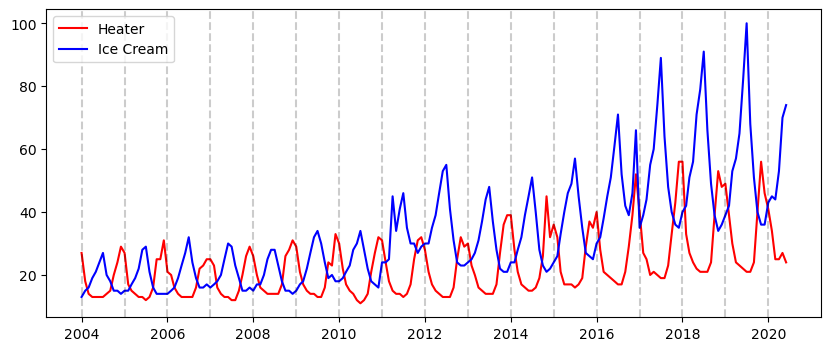

In [6]:
plt.figure(figsize = (10,4))
plt.plot(df['heater'], c = 'r')
plt.plot(df['ice cream'], c = 'b')
plt.legend(['Heater', 'Ice Cream'])

for year in range(2004, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

#### Goal : predict heater value using itself and the lagged value of icecream 

We see that both the time series are not stationary. Lets normalize the value and then make it stationary

## Normalize

In [7]:
avgs = df.mean()
std_dev = df.std()

In [8]:
for col in df.columns:
    df[col] = (df[col] - avgs[col])/std_dev[col]

In [9]:
df

,heater,ice cream
Month,,
2004-01-01,0.429490,-1.174946
2004-02-01,-0.489299,-1.057807
2004-03-01,-0.897650,-0.999237
2004-04-01,-0.999738,-0.823527
2004-05-01,-0.999738,-0.706388
...,...,...
2020-02-01,1.144104,0.699288
2020-03-01,0.225315,0.640719
2020-04-01,0.225315,1.167847


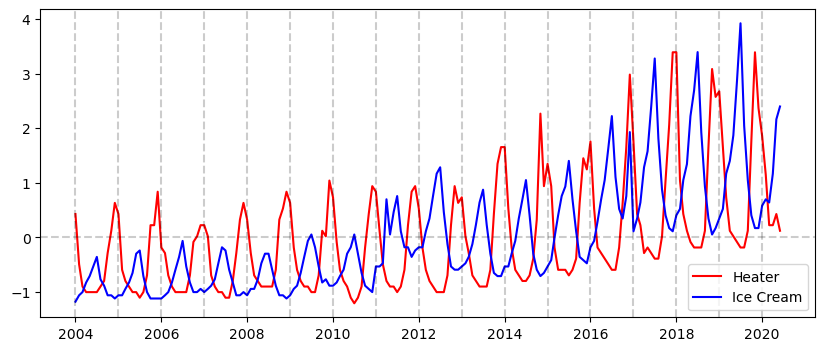

In [10]:
plt.figure(figsize = (10,4))
plt.plot(df['heater'], c = 'r')
plt.plot(df['ice cream'], c = 'b')
plt.legend(['Heater', 'Ice Cream'])

for year in range(2004, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

plt.axhline(0, c = 'k', alpha = 0.2, linestyle = '--') 

## Taking first differnce

In [11]:
df_diff = df.diff().dropna()

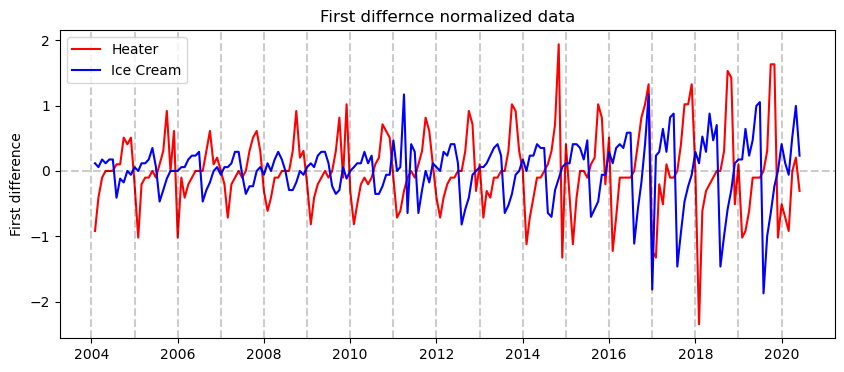

In [12]:
plt.figure(figsize = (10,4))
plt.plot(df_diff['heater'], c = 'r')
plt.plot(df_diff['ice cream'], c = 'b')
plt.legend(['Heater', 'Ice Cream'])
plt.title('First differnce normalized data')
plt.ylabel('First difference')
for year in range(2004, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

plt.axhline(0, c = 'k', alpha = 0.2, linestyle = '--') 

**We see that still the volatility increases over time, we need to get rid of it**

## Removing increasing volatility

In [13]:
annual_volatility = df_diff.groupby(df_diff.index.year).std()

In [14]:
annual_volatility

,heater,ice cream
Month,,
2004,0.415481,0.184201
2005,0.474527,0.214837
2006,0.400148,0.227698
2007,0.359839,0.198947
2008,0.396182,0.183239
2009,0.499810,0.221038
2010,0.459566,0.211668
2011,0.443924,0.501018
2012,0.471104,0.389711


In [15]:
df_diff['ice_cream_annual_vol'] = df_diff.index.map(lambda x: annual_volatility.loc[x.year, 'ice cream'])
df_diff['heater_annual_vol'] = df_diff.index.map(lambda x: annual_volatility.loc[x.year, 'heater'])


In [16]:
df_diff

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
2004-02-01,-0.918789,0.117140,0.184201,0.415481
2004-03-01,-0.408351,0.058570,0.184201,0.415481
2004-04-01,-0.102088,0.175710,0.184201,0.415481
2004-05-01,0.000000,0.117140,0.184201,0.415481
2004-06-01,0.000000,0.175710,0.184201,0.415481
...,...,...,...,...
2020-02-01,-0.714614,0.117140,0.369810,0.426657
2020-03-01,-0.918789,-0.058570,0.369810,0.426657
2020-04-01,0.000000,0.527129,0.369810,0.426657


In [17]:
df_diff['ice cream'] = df_diff['ice cream']/df_diff['ice_cream_annual_vol']
df_diff['heater'] = df_diff['heater']/df_diff['heater_annual_vol']


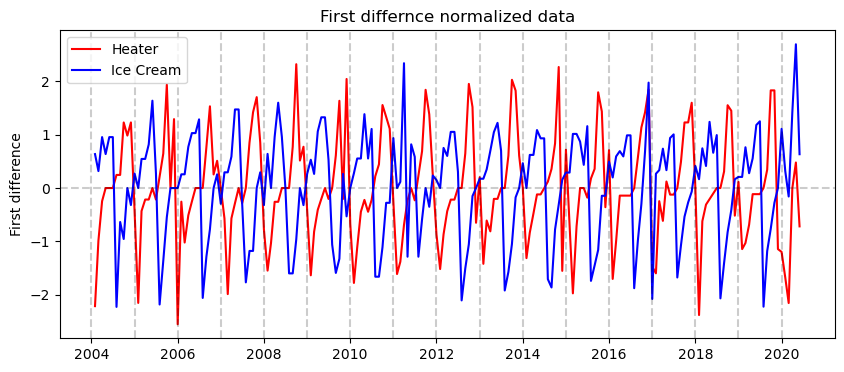

In [18]:
plt.figure(figsize = (10,4))
plt.plot(df_diff['heater'], c = 'r')
plt.plot(df_diff['ice cream'], c = 'b')
plt.legend(['Heater', 'Ice Cream'])
plt.title('First differnce normalized data')
plt.ylabel('First difference')
for year in range(2004, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

plt.axhline(0, c = 'k', alpha = 0.2, linestyle = '--') 

**We still see there is seasonality in the time series data. And in order to make it stationary and use various model, we need to get rid of seasonality too**

## Remove seasonality

To remove seasonality, we need to subtract the values in month by the average of value of that particular month over years

In [19]:
month_avg = df_diff.groupby(df_diff.index.month).mean()

In [20]:
month_avg

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
1,-0.428360,0.130345,0.415976,0.580717
2,-1.483129,0.250194,0.402342,0.570997
3,-1.063595,0.433016,0.402342,0.570997
4,-0.442926,0.838085,0.402342,0.570997
5,-0.121663,0.967273,0.402342,0.570997
6,-0.128425,0.987311,0.402342,0.570997
7,-0.107093,0.735052,0.404376,0.580018
8,0.075720,-1.821285,0.404376,0.580018
9,0.544638,-1.307661,0.404376,0.580018


In [21]:
df_diff['ice_cream_month_avg'] = df_diff.index.map(lambda x: month_avg.loc[x.month, 'ice cream'])
df_diff['heater_month_avg'] = df_diff.index.map(lambda x: month_avg.loc[x.month, 'heater'])


In [22]:
df_diff['ice cream'] = df_diff['ice cream'] - df_diff['ice_cream_month_avg']
df_diff['heater'] = df_diff['heater'] - df_diff['heater_month_avg']

In [23]:
df_diff

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-0.728257,0.385740,0.184201,0.415481,0.250194,-1.483129
2004-03-01,0.080757,-0.115049,0.184201,0.415481,0.433016,-1.063595
2004-04-01,0.197217,0.115816,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.121663,-0.331339,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.128425,-0.033411,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-0.191787,0.066562,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-1.089868,-0.591394,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.442926,0.587318,0.369810,0.426657,0.838085,-0.442926


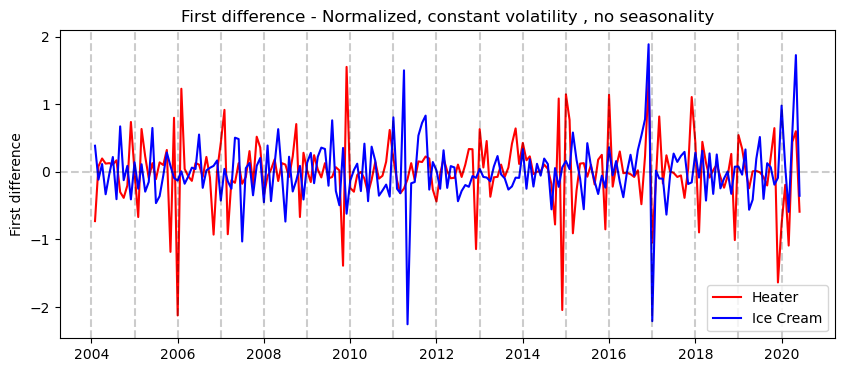

In [47]:
plt.figure(figsize = (10,4))
plt.plot(df_diff['heater'], c = 'r')
plt.plot(df_diff['ice cream'], c = 'b')
plt.legend(['Heater', 'Ice Cream'])
plt.title('First difference - Normalized, constant volatility , no seasonality')
plt.ylabel('First difference')
for year in range(2004, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

plt.axhline(0, c = 'k', alpha = 0.2, linestyle = '--') 

## PACF heater 

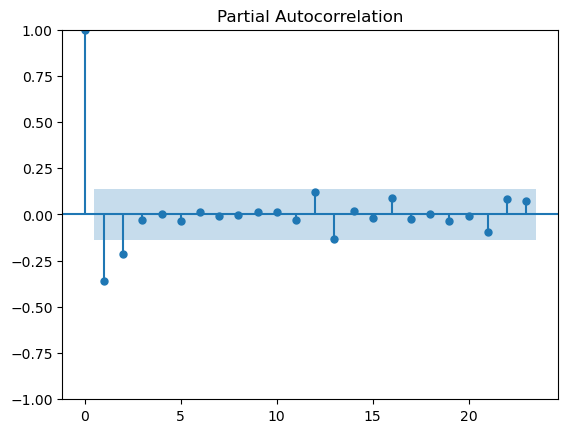

In [26]:
plot_pacf = plot_pacf(df_diff['heater'])

#### So considering AR(2) for heater

**But the question is what lag should we use for ice cream data**

### Correlation between "heater" and lagged "ice cream"


In [35]:
## For the Pearson correlation coefficient calculation to be valid, the lengths of the two datasets must be the same

for lag in range(1, 15): #using 14 as the last most important PACF was at 13ish
    heater_Series = df_diff['heater'].iloc[lag:]
    lagged_icecream_Series = df_diff['ice cream'].iloc[:-lag]

    print('Lag :', lag)
    print(pearsonr(heater_Series, lagged_icecream_Series))
    print('-------')

Lag : 1
PearsonRResult(statistic=-0.03154450742591571, pvalue=0.6607284991749393)
-------
Lag : 2
PearsonRResult(statistic=-0.0987270321094464, pvalue=0.1697084190508977)
-------
Lag : 3
PearsonRResult(statistic=-0.001783855378923544, pvalue=0.9803056762960981)
-------
Lag : 4
PearsonRResult(statistic=0.06023971859825535, pvalue=0.405297983252864)
-------
Lag : 5
PearsonRResult(statistic=-0.05403486448015027, pvalue=0.45664426275056885)
-------
Lag : 6
PearsonRResult(statistic=0.06461183026553836, pvalue=0.37453000434454253)
-------
Lag : 7
PearsonRResult(statistic=-0.04949334618415865, pvalue=0.497687668576209)
-------
Lag : 8
PearsonRResult(statistic=0.0789083713597735, pvalue=0.28045489704330495)
-------
Lag : 9
PearsonRResult(statistic=-0.05323501699600424, pvalue=0.4681034202228023)
-------
Lag : 10
PearsonRResult(statistic=0.029536989060791184, pvalue=0.6882054906333287)
-------
Lag : 11
PearsonRResult(statistic=-0.05979536351522567, pvalue=0.4175217420485689)
-------
Lag : 12
Pe

##### We want the lag for which pvalue is less than 0.05, and it seems lag 13 fits well for that.

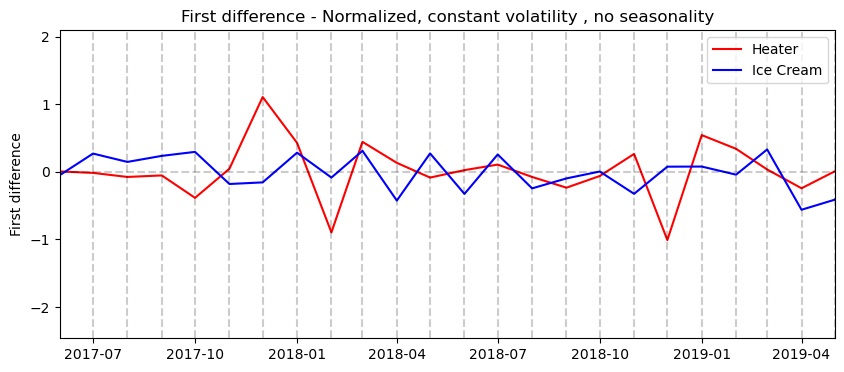

In [61]:
### looking more closely at lag 13 

plt.figure(figsize = (10,4))
plt.plot(df_diff['heater'], c = 'r')
plt.plot(df_diff['ice cream'], c = 'b')
plt.legend(['Heater', 'Ice Cream'])
plt.title('First difference - Normalized, constant volatility , no seasonality')
plt.ylabel('First difference')
plt.xlim(pd.to_datetime('2017-06-01'), pd.to_datetime('2019-05-01'))

for month in range(1, 13):
    plt.axvline(pd.to_datetime('2017-' + str(month) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

for month in range(1, 13):
    plt.axvline(pd.to_datetime('2018-' + str(month) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 

for month in range(1, 12):
    plt.axvline(pd.to_datetime('2019-' + str(month) + '-01'), c = 'k', alpha = 0.2, linestyle = '--') 


plt.axhline(0, c = 'k', alpha = 0.2, linestyle = '--') 

## Fit a VAR model

In [62]:
new_df = df_diff[['ice cream', 'heater']]

In [65]:
model = VAR(new_df).fit(maxlags = 13)

model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 08, Aug, 2024
Time:                     13:15:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation ice cream
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.016054         0.034105           -0.471           0.638
L1.ice cream         -0.287811         0.079633           -3.614           0.000
L1.heater            -0.121251         0.073673         

#### We will focus on Results for equation heater and look at the corresponding 'prob' column which can be taken similar to pvalue. So we want coefficients whose prob value is less than 0.05

- L1.heater
- L2.heater
- L13.ice cream 

L1 and L2 heater are similar to what we looked from the PACF plot of heater

## Final model for heater is 

$h_t = -0.405 ~h_{t-1} + -0.193~ h_{t-1} + 0.203~ i_{t-13}$

where i is for icecream and h is for heater 
